In [36]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten , Dropout,BatchNormalization
from tensorflow.keras.models import Model
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [37]:
IMAGE_SIZE = [128, 128]

path = '/kaggle/input/merged-data/Merged_Data'

In [38]:
# Train Test Split
!pip install split-folders
import splitfolders

In [39]:
splitfolders.ratio(path, output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 4310 files [00:10, 414.04 files/s]


In [40]:
# add preprocessing layer to the front of VGG
r = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [41]:
# don't train existing weights
for layer in r.layers:
  layer.trainable = False

In [42]:
  # useful for getting number of classes
folders = glob('/kaggle/input/merged-data/Merged_Data/*')

In [43]:
# our layers - you can add more if you want
x = Flatten()(r.output)
x = Dense(1028,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(514,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)

prediction = Dense(len(folders), activation='softmax')(x)

In [44]:
# create a model object
model = Model(inputs=r.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [45]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [46]:
from tensorflow import keras
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [47]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/kaggle/working/output/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/kaggle/working/output/val',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 3446 images belonging to 4 classes.
Found 864 images belonging to 4 classes.


In [48]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[early_stop]
)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


108/108 [==============================] - 23s 170ms/step - loss: 1.1798 - accuracy: 0.5221 - val_loss: 2.9234 - val_accuracy: 0.3484
Epoch 2/50
108/108 [==============================] - 19s 174ms/step - loss: 0.9295 - accuracy: 0.6262 - val_loss: 1.2084 - val_accuracy: 0.5417
Epoch 3/50
108/108 [==============================] - 18s 164ms/step - loss: 0.8304 - accuracy: 0.6680 - val_loss: 1.0076 - val_accuracy: 0.5972
Epoch 4/50
108/108 [==============================] - 19s 172ms/step - loss: 0.7868 - accuracy: 0.6759 - val_loss: 0.8970 - val_accuracy: 0.6493
Epoch 5/50
108/108 [==============================] - 19s 176ms/step - loss: 0.7360 - accuracy: 0.7023 - val_loss: 0.8179 - val_accuracy: 0.6748
Epoch 6/50
108/108 [==============================] - 18s 166ms/step - loss: 0.6796 - accuracy: 0.7351 - val_loss: 1.4491 - val_accuracy: 0.4572
Epoch 7/50
108/108 [==============================] - 18s 170ms/step - loss: 0.6855 - accuracy: 0.7353 - val_loss: 0.9452 - val_accuracy: 0.6

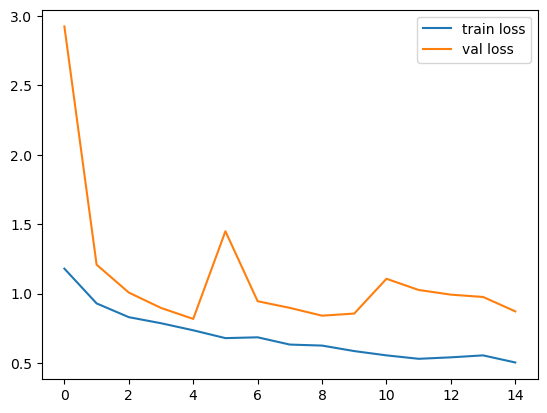

<Figure size 640x480 with 0 Axes>

In [49]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

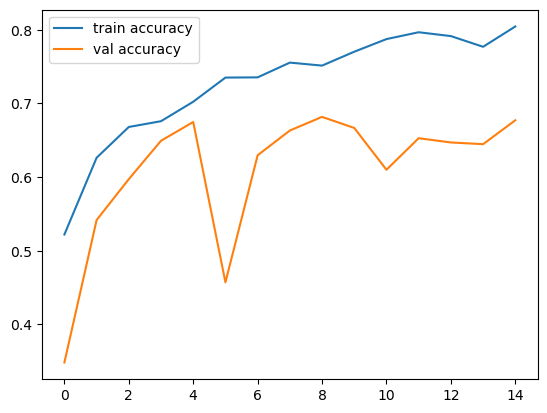

<Figure size 640x480 with 0 Axes>

In [50]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [51]:
import tensorflow as tf
from keras.models import load_model
model.save('model1.h5')